# QLSC 600 - Module 4 - Assignment 1
Andrew Doyle

25 November, 2019

# 1. Load data and visualize

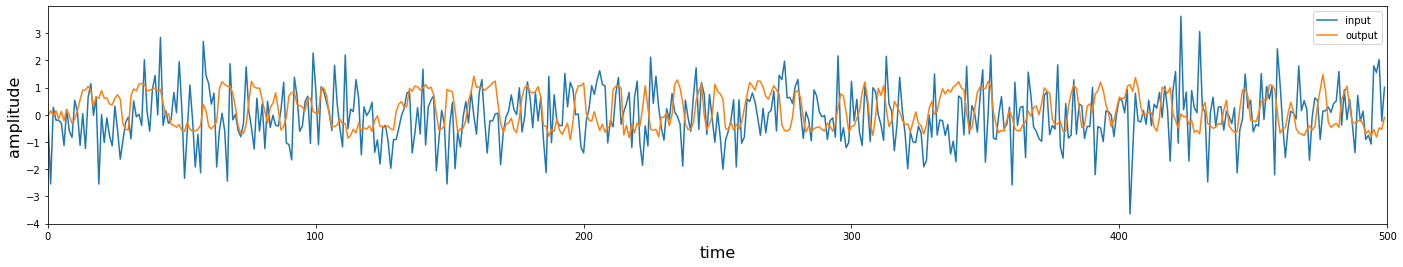

In [1]:
%matplotlib inline
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt

filename = "C:/Users/doyle/Downloads/assignment1Data.mat"

matfile = loadmat(filename)

s = matfile['s']
o = matfile['o']

signal_length = s.shape[0]

time = range(signal_length)

fig = plt.figure(figsize=(24, 4))
plt.plot(time, s, label='input')
plt.plot(time, o, label='output')
plt.legend()
plt.xlim([0, 500])
plt.xlabel('time', fontsize=16)
plt.ylabel('amplitude', fontsize=16)
plt.show()

# 2. Create design matrix

The design matrix A from the equation Af = O allows us to estimate the parameters of the best linear system (f) that explain the output.

In [2]:
window_size = 20

A, O = [], []

for i in range(signal_length - window_size):
    A.append(np.hstack((s[i:i+window_size-1, 0][::-1], 1)))
    O.append(o[i+window_size,0])
    
A = np.asarray(A)
O = np.asarray(O)[:, np.newaxis]

# print(A.shape, O.shape)
# print(s[0:20, 0])
# print(A[:, 0])

In [3]:
# from scipy.linalg import toeplitz
# A = toeplitz(s, s)

# 3. Estimate impulse response
The impulse response is our estimated reaction of the system for an impulse (dirac delta function).

(480, 20) (480, 1)
dc offset: [0.11086589]


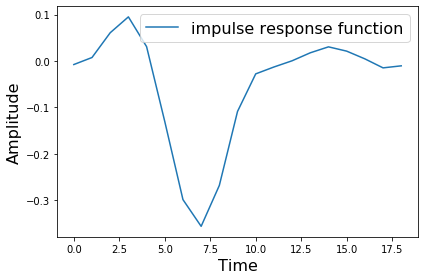

In [4]:
from numpy.linalg import lstsq

print(A.shape, O[:, 0:window_size].shape)

f, res, rank, _ = lstsq(A, O[:, 0:window_size], rcond=None)
k = f[-1]

print('dc offset:', k)

irf = f[:-1][::-1]

plt.plot(irf, label='impulse response function')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

# 4. Plot linear system approximate output
The linear system explains the output data fairly well, with 0.8 of the variance accounted for.

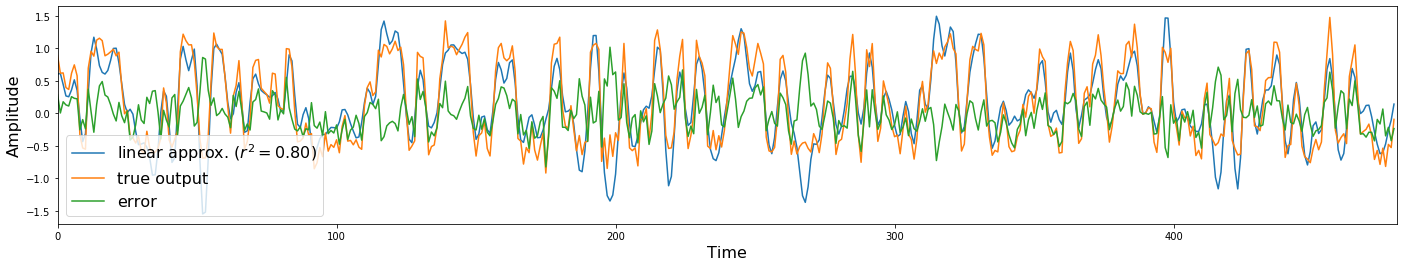

In [5]:
from sklearn.metrics import r2_score

linear_system_output = np.matmul(A, f)[:, 0]
true_output = o[window_size:, 0]

error = true_output - linear_system_output

r2 = r2_score(true_output, linear_system_output)

fig = plt.figure(figsize=(24, 4))
plt.plot(linear_system_output, label='linear approx. ($r^2={0:.2f}$)'.format(r2))
plt.plot(true_output, label='true output')
plt.plot(error, label='error')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.xlim([0, signal_length-window_size])
plt.legend(fontsize=16)
plt.show()

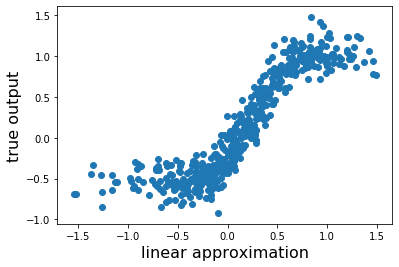

In [6]:
plt.scatter(linear_system_output, true_output)
plt.xlabel('linear approximation', fontsize=16)
plt.ylabel('true output', fontsize=16)
plt.show()

# 5. Estimate static non-linearity
In the above plot, the approximate vs. true output reveals that for the lower and higher values, our model does worse at explaining the behaviour of the system, suggesting a static non-linearity. In this section, we optimize the parameters of a non-linearity containing: 1) a linear component, 2) sigmoidal component with a shape parameter and 3) a second-order component. This increases our variance accounted for by 0.11 but is almost certainly overfitting the data.

C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


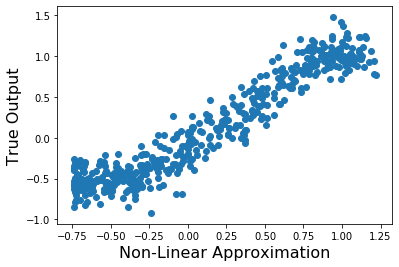

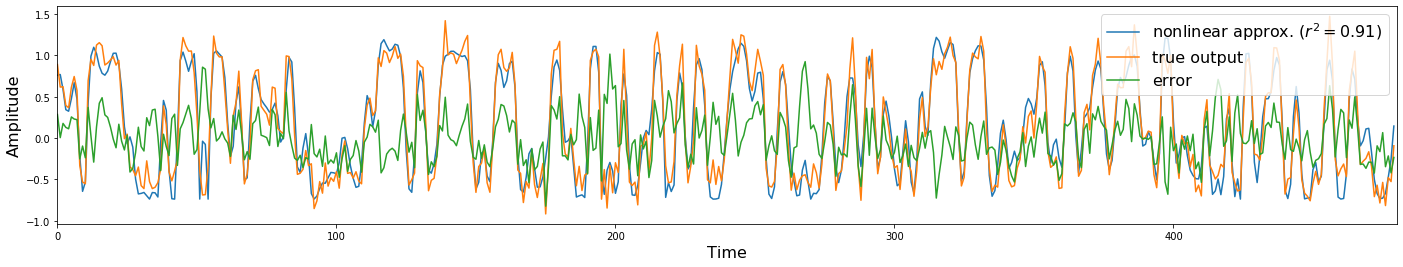

In [7]:
from scipy.optimize import curve_fit

def nonlin(x, a, b, c, d, e, f):
    y = a*x + b + (c / (1 + np.exp(-d*x))) + e*(x**2)
    return y

(a_opt, b_opt, c_opt, d_opt, e_opt, f_opt), (covariance) = curve_fit(nonlin, linear_system_output, true_output)

# print(a_opt, b_opt, c_opt, d_opt)

nonlinear_output = nonlin(linear_system_output, a_opt, b_opt, c_opt, d_opt, e_opt, f_opt)

plt.scatter(nonlinear_output, true_output)
plt.xlabel('Non-Linear Approximation', fontsize=16)
plt.ylabel('True Output', fontsize=16)
plt.show()

r2 = r2_score(true_output, nonlinear_output)

fig = plt.figure(figsize=(24, 4))
plt.plot(nonlinear_output, label='nonlinear approx. ($r^2={0:.2f}$)'.format(r2))
plt.plot(true_output, label='true output')
plt.plot(error, label='error')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.xlim([0, signal_length-window_size])
plt.legend(fontsize=16)
plt.show()

The true output vs. non-linear approximation now appears much closer, and the error is reduced when examining the time series.